## Net Returns Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> The net returns maximization module is experiemental. </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level). Behind the scene, we use the `SLSQP` method from `scipy.optim`. It is recommended to learn basic from the [tutorial](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy

# for version print
import orbit
import scipy

from karpiu.planning.optim import ChannelNetProfitMaximizer, TimeNetProfitMaximizer
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import AttributorBeta as Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(pd.__version__)
print(np.__version__)
print(scipy.__version__)

1.1.4.2
1.4.2
1.24.2
1.10.0


Bring back the fitted model from previous `Quickstart` section.

In [4]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-03-31")
optim_channels = mmm.get_spend_cols()

Given the customers life-time value (LTV), one can run the revenue maximization.

In [6]:
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]

### Two-Stage Optimization

#### Optimizing Channel Budget

First, we optimize the budget mix.

In [7]:
%%time
ch_npm = ChannelNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.0,
    response_scaler=1.0,
)

CPU times: user 23.1 ms, sys: 1.29 ms, total: 24.4 ms
Wall time: 23.8 ms


In [8]:
temp_optim_spend_df = ch_npm.optimize(maxiter=500, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -315928.08459084656
            Iterations: 78
            Function evaluations: 479
            Gradient evaluations: 78


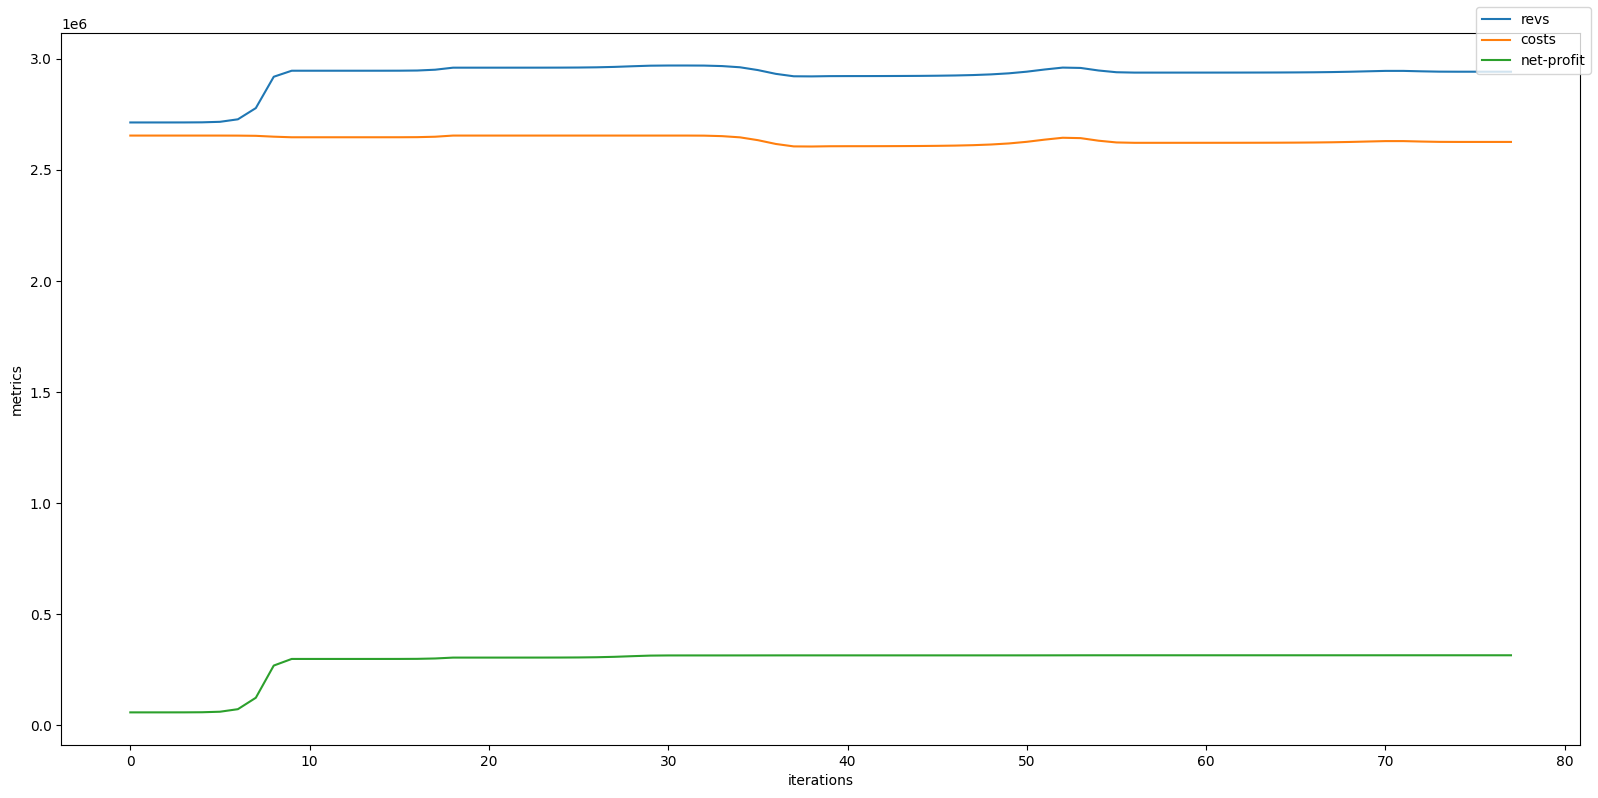

In [9]:
# expermential plot the revs and costs
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
callback_metrics = ch_npm.get_callback_metrics()

optim_revenues = np.array(callback_metrics["optim_revenues"])
optim_costs = np.array(callback_metrics["optim_costs"])

ax.plot(optim_revenues, label="revs")
ax.plot(optim_costs, label="costs")
ax.plot(optim_revenues - optim_costs, label="net-profit")
ax.set_xlabel("iterations")
ax.set_ylabel("metrics")
fig.legend()
fig.tight_layout();

We can retreive the initial and final state of the optimization.

In [10]:
channel_spend_arr = ch_npm.get_current_state()
init_spend_arr = ch_npm.get_init_state()
init_spend_matrix = ch_npm.get_init_spend_matrix()

In [11]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(channel_spend_arr)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_arr)))

Suggested total spend: 1298464
Total Budget: 1327092


#### Optimizing Budget Allocation across Time

Second, given the condition of budget mix, we optimize the allocation across time.

In [12]:
temp_mmm = deepcopy(mmm)
temp_mmm.raw_df = temp_optim_spend_df
t_npm = TimeNetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=temp_mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=1e-4,
    spend_scaler=1.0,
    response_scaler=1.0,
)
# remove all constraints
t_npm.set_constraints([])

In [13]:
optim_spend_df = t_npm.optimize(maxiter=500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -689602.2490713813
            Iterations: 341
            Function evaluations: 30940
            Gradient evaluations: 340


In [14]:
optim_spend_matrix = t_npm.get_current_spend_matrix()

In [15]:
time_based_spend_arr = t_npm.get_current_state()

In [16]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 638736
Total Budget: 1327092


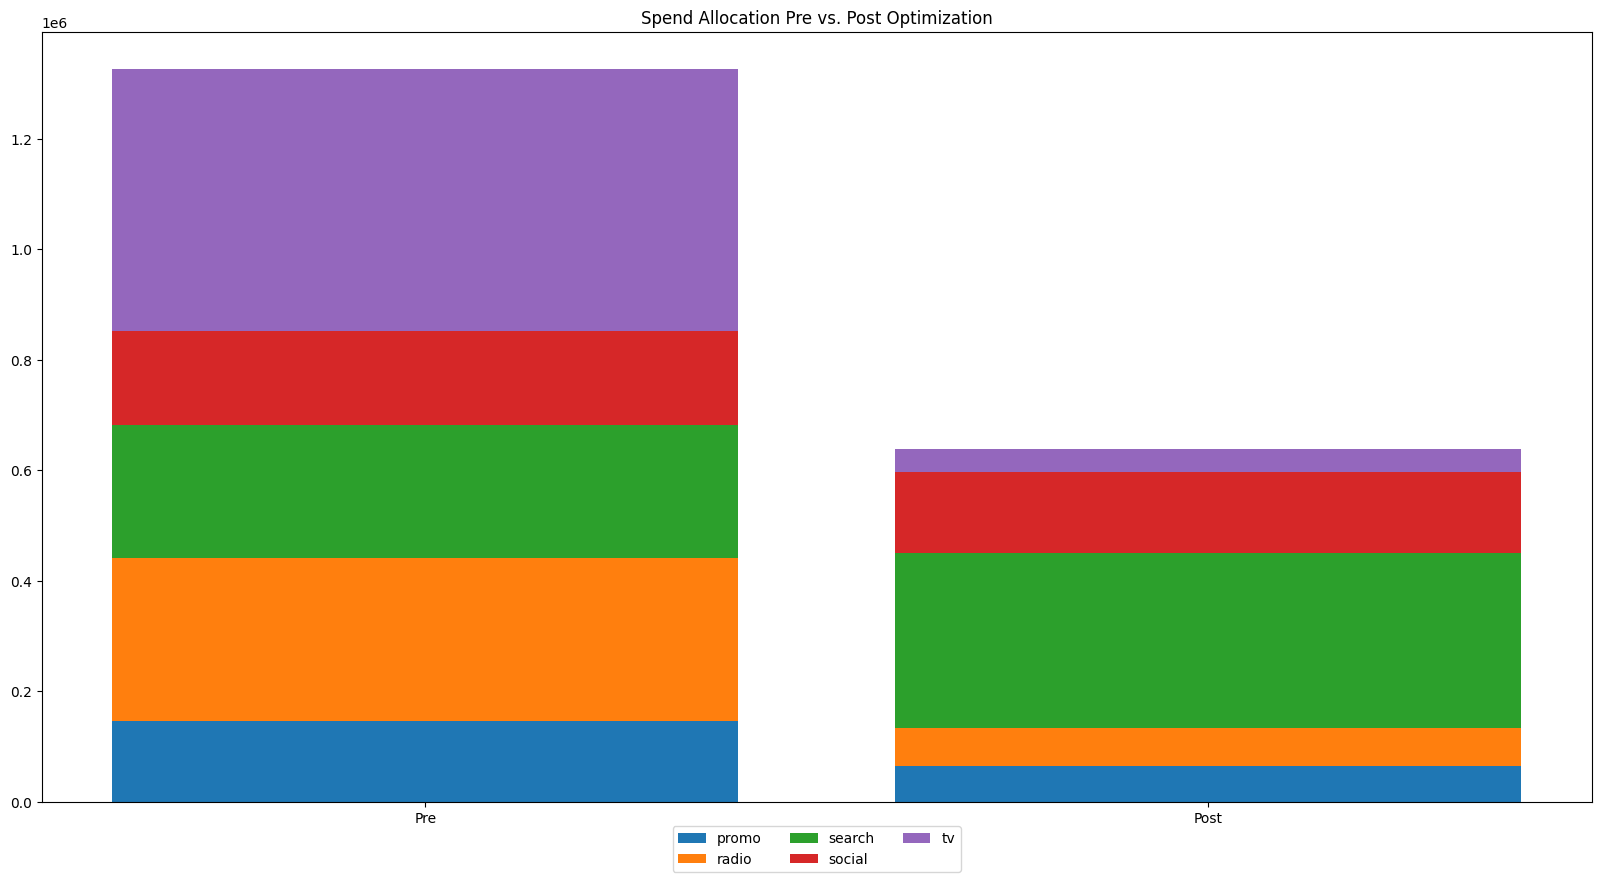

In [17]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Validation

#### Average and Marginal Cost Change

In general, one should expect when LTV is greater than the marginal cost under the pre-optimized spend, there should be an increase of spend in the optimal budget. 

In [18]:
df = mmm.get_raw_df()

In [19]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,41.47176,22.81263,59.97606,29.76403,145.95900,64.73299,48.50000
radio,65.87096,26.04703,104.42140,30.47605,294.95500,69.40385,52.50000
search,27.14218,21.96794,33.52774,30.59213,240.82900,316.33721,38.60000
social,29.39481,19.12241,41.36934,27.28041,171.27100,147.20721,35.80000
tv,88.57685,29.51699,134.86953,29.65254,474.07800,41.05520,60.80000


In [20]:
pre_mc = cost_report["pre-opt-marginal-cost"].values
overspend = pre_mc > (cost_report["ltv"].values * 1.2)
underspend = pre_mc < (cost_report["ltv"].values * 0.8)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

After all, a general condition of marginal cost lower than LTV should be met when spend > 0.

In [21]:
post_mc = cost_report["post-opt-marginal-cost"].values

In [22]:
assert np.all(post_mc < cost_report["ltv"].values * 1.1)

#### Spend Allocation Plot

Channels mix comparison

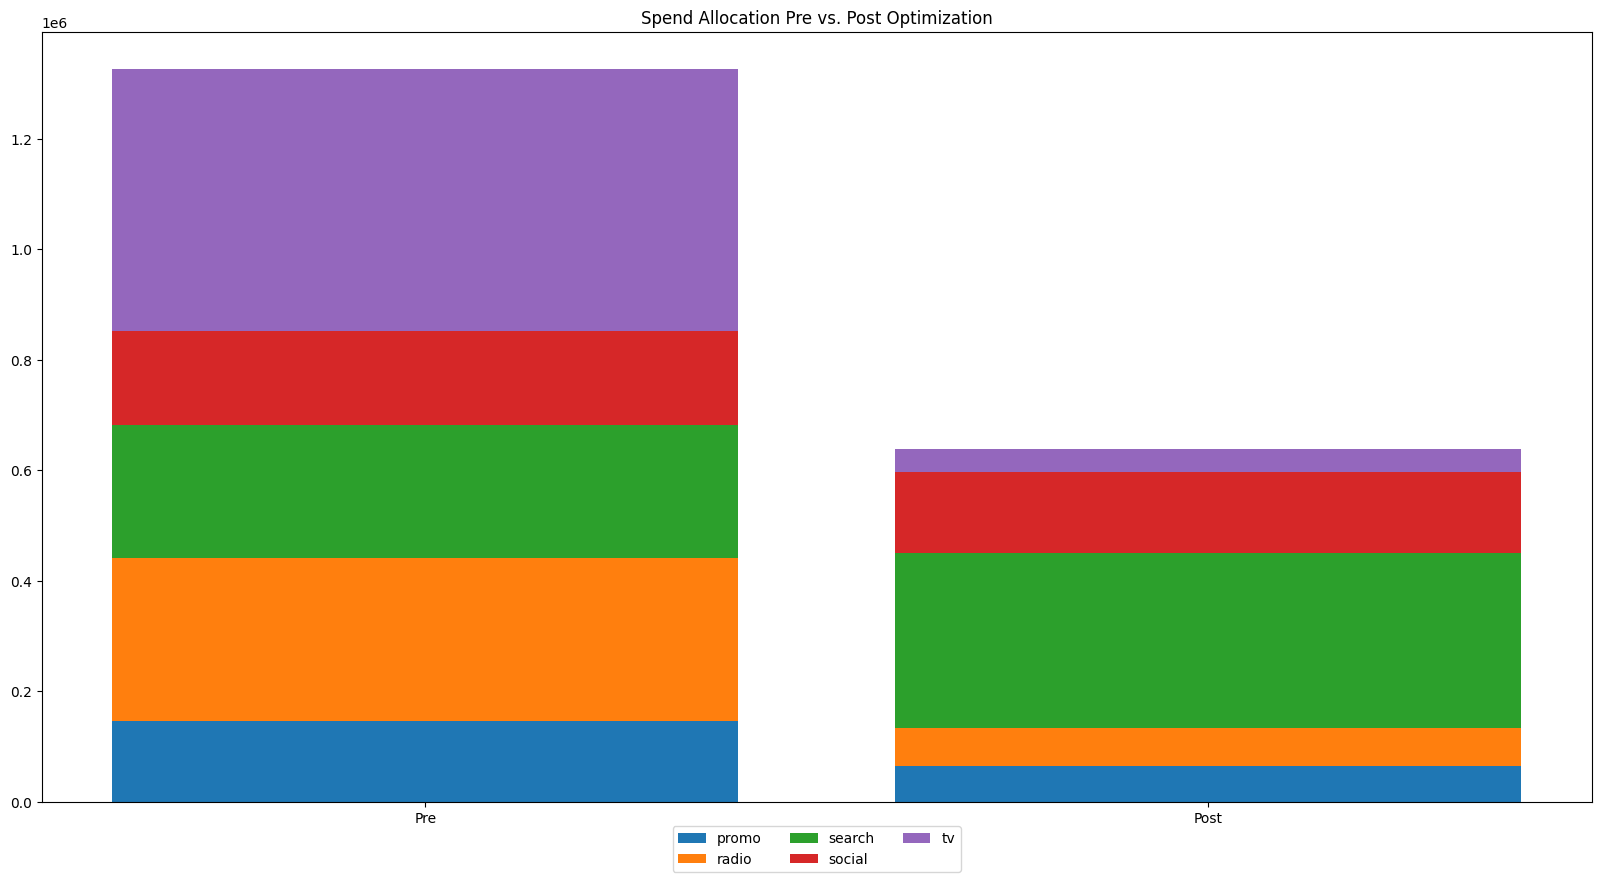

In [23]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

Time-based allocation

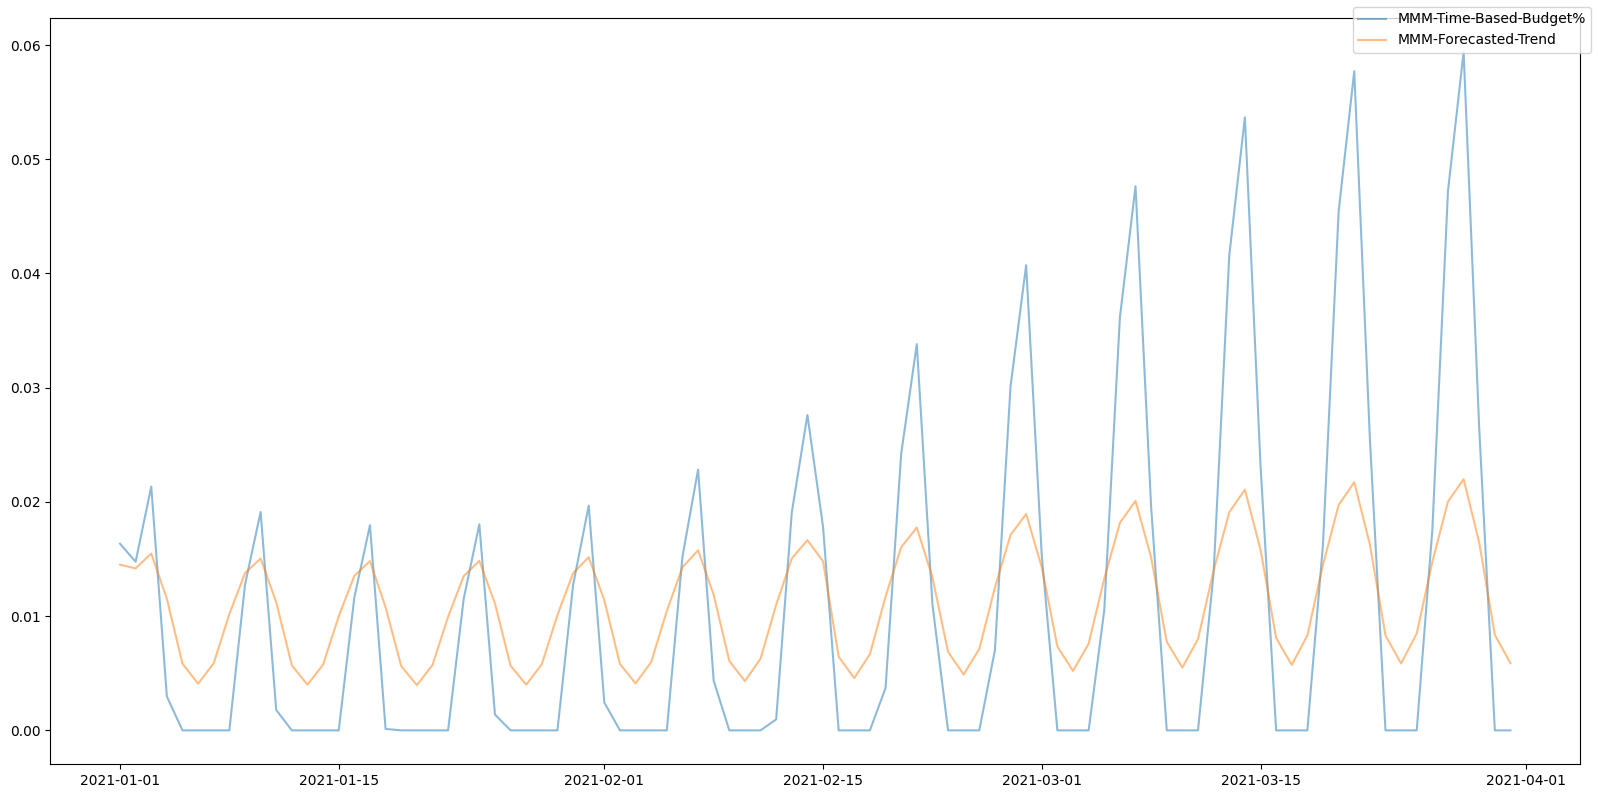

In [24]:
t_based_allocation_comp = t_npm.get_current_state()
base_comp_calc = t_npm.base_comp_input
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    pd.date_range(budget_start, budget_end, freq="1D"),
    t_based_allocation_comp / np.sum(t_based_allocation_comp),
    label="MMM-Time-Based-Budget%",
    alpha=0.5,
)
ax.plot(
    pd.date_range(budget_start, budget_end, freq="1D"),
    base_comp_calc / np.sum(base_comp_calc),
    label="MMM-Forecasted-Trend",
    alpha=0.5,
)
fig.legend()
fig.tight_layout()

### Customize Budget Constraints and Bounds

#### Channels mix

The channel "total" is a special reserved to specify total budget constraint. When lower bound and upper bound are equal, it enforce the budget total fixed.

In [25]:
bounds_and_constraints_df = pd.DataFrame(
    {
        "channels": optim_channels + ["total"],
        "upper": np.array(
            [291918.0, 589910.0, 481658.0, 342542.0, 948156.0, 1327092.0]
        ),
        "lower": np.array([14595.9, 29495.5, 24082.9, 17127.1, 47407.8, 1327092.0]),
    }
)
bounds_and_constraints_df

,channels,upper,lower
0,promo,291918.00000,14595.90000
1,radio,589910.00000,29495.50000
2,search,481658.00000,24082.90000
3,social,342542.00000,17127.10000
4,tv,948156.00000,47407.80000
5,total,1327092.00000,1327092.00000


In [26]:
ch_npm.set_bounds_and_constraints(df=bounds_and_constraints_df)

#### Time-based allocaton

Similar to channels mix, "total" is a reserved keyword.

In [27]:
bounds_and_constraints_df = pd.DataFrame(
    {
        "date": t_npm.df.loc[t_npm.budget_mask, "date"].astype(str).to_list()
        + ["total"],
        "upper": np.concatenate(
            [np.ones(t_npm.n_budget_steps) * 30000, np.ones(1) * 1327092]
        ),
        "lower": np.concatenate([np.zeros(t_npm.n_budget_steps), np.ones(1) * 1327092]),
    }
)
bounds_and_constraints_df

,date,upper,lower
0,2021-01-01,30000.00000,0.00000
1,2021-01-02,30000.00000,0.00000
2,2021-01-03,30000.00000,0.00000
3,2021-01-04,30000.00000,0.00000
4,2021-01-05,30000.00000,0.00000
...,...,...,...
86,2021-03-28,30000.00000,0.00000
87,2021-03-29,30000.00000,0.00000
88,2021-03-30,30000.00000,0.00000
89,2021-03-31,30000.00000,0.00000


In [28]:
t_npm.set_bounds_and_constraints(bounds_and_constraints_df)